In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 500)

from sklearn import svm
import re
from shutil import copyfile
import matplotlib.pyplot as plt
import pydicom
from tqdm import tqdm
import dicom2nifti
import nibabel as nib


## Notebook to trim the dataset from NDA to only the needed files

Most of this should be standard except at towards the bottom there are two ways to verify correct files. 

In [2]:
# for 2274:
path = '../physcosis/Package_1187332/'

# should be standard
test_file = 'panss01.txt'
subject_file = 'ndar_subject01.txt'
image_file = 'image03.txt'




In [3]:
# opensfiles using pandas
# drop rows that are fully duplicated from the start --> not need 
ndar_subject = pd.read_csv(os.path.join(path, subject_file), delimiter = '\t')
print(ndar_subject.shape)
ndar_subject = ndar_subject.drop_duplicates()
print(ndar_subject.shape)
test = pd.read_csv(os.path.join(path, test_file), delimiter = '\t')
print(test.shape)
test = test.drop_duplicates()
print(test.shape)
image03 = pd.read_csv(os.path.join(path, image_file), delimiter = '\t')
print(image03.shape)
image03 = image03.drop_duplicates()
print(image03.shape)

(4404, 26)
(4404, 26)
(1779, 42)
(1779, 42)
(9395, 51)
(9395, 51)


In [4]:
# shows the different types of images available for the data package
image03.pivot_table(columns = ['image_description'], aggfunc = 'size')

image_description
ADNI Double_TSE SENSE                                                      561
ADNI MPRAGE SENSE                                                           45
ADNI MPRAGE pg7 SENSE                                                      516
AX T2                                                                       16
Axial PD-T2 TSE                                                            118
Axial PD-T2 TSE no angle                                                    73
Axial PD-T2 TSE_ NO ANGULATION                                               4
Axial PD-T2 TSE_NO_ANGLE                                                    26
B1-Calibration Body                                                         98
B1-Calibration Body_COIL                                                    25
B1-Callibration Head                                                        98
B1-Callibration Head_COIL                                                   24
Bsnip Ax PD-T2 TSE NoAng          

In [5]:
image03.pivot_table(columns = ['scan_type'], aggfunc = 'size')

scan_type
MR diffusion          3882
MR structural (T1)    2902
MR structural (T2)     977
Type of Scan             1
fMRI                  1633
dtype: int64

In [6]:
image03 = image03[image03['scan_type'].isin(['MR structural (T1)'])]
image03.shape

(2902, 51)

In [7]:
data_dir = os.path.join(path, 'image03')

#### CHANGE BASED ON WHAT 'image_file' COLUMN LOOKS LIKE IN image03 (corrects the file path to be on local machine) ####

# for 2274:
regex ='s3://NDAR_.*/submission_.[0-9]*/'


rows_with_bad_path = []
for index, row in image03.iterrows():
    image_path = re.sub(regex, '', row['image_file'])
    full_path = os.path.join(data_dir, image_path)
#     print(full_path)
    if not os.path.exists(full_path):
        print(image_path, index, row['image_file'])
        rows_with_bad_path.append(index)
rows_with_bad_path

[]

In [8]:
# drops rows based on rows with bad path and replaces old paths with local paths

image03 = image03.drop(rows_with_bad_path)
l = []

for index, row in image03.iterrows():
    image_path = re.sub(regex, '', row['image_file'])
    full_path = os.path.join(data_dir, image_path)
    l.append(full_path)
image03['image_file'] = l
image03.shape

(2902, 51)

In [9]:
# count number of unique subject ids in the panss test 
print(test['src_subject_id'].nunique())
print(test.columns)
print(test.shape)
# I think only these are needed change is using another test
test = test[['src_subject_id', 'interview_age', 'panss_general',
       'panss_negative', 'panss_positive', 'pos_p1', 'pos_p2', 'pos_p3',
       'pos_p4', 'pos_p5', 'pos_p6', 'pos_p7', 'neg_n1', 'neg_n2', 'neg_n3',
       'neg_n4', 'neg_n5', 'neg_n6', 'neg_n7', 'gps_g1', 'gps_g2', 'gps_g3',
       'gps_g4', 'gps_g5', 'gps_g6', 'gps_g7', 'gps_g8', 'gps_g9', 'gps_g10',
       'gps_g11', 'gps_g12', 'gps_g13', 'gps_g14', 'gps_g15', 'gps_g16']]
test.pivot_table(columns = ['src_subject_id', 'interview_age'], aggfunc = 'size')
# drop duplicate tests for subjects
test = test.drop_duplicates(subset = ['src_subject_id', 'interview_age'])
print(test.shape)

968
Index(['collection_id', 'panss01_id', 'dataset_id', 'subjectkey',
       'src_subject_id', 'interview_age', 'sex', 'panss_general',
       'panss_negative', 'panss_positive', 'panss_total', 'pos_p1', 'pos_p2',
       'pos_p3', 'pos_p4', 'pos_p5', 'pos_p6', 'pos_p7', 'neg_n1', 'neg_n2',
       'neg_n3', 'neg_n4', 'neg_n5', 'neg_n6', 'neg_n7', 'gps_g1', 'gps_g2',
       'gps_g3', 'gps_g4', 'gps_g5', 'gps_g6', 'gps_g7', 'gps_g8', 'gps_g9',
       'gps_g10', 'gps_g11', 'gps_g12', 'gps_g13', 'gps_g14', 'gps_g15',
       'gps_g16', 'collection_title'],
      dtype='object')
(1779, 42)
(968, 35)


In [10]:
print(ndar_subject.shape)
ndar_subject.pivot_table(columns = ['src_subject_id', 'interview_age'], aggfunc = 'size')
print(ndar_subject.shape)
ndar_subject = ndar_subject.drop_duplicates(subset = ['src_subject_id', 'interview_age'])
print(ndar_subject.shape)

(4404, 26)
(4404, 26)
(2416, 26)


In [11]:
res1 = image03.merge(ndar_subject, on = ['src_subject_id', 'interview_age'], how = 'inner')
print(res1.shape)
res2 = res1.merge(test,  on = ['src_subject_id', 'interview_age'], how = 'inner')


# print(res2['src_subject_id'].nunique())
print(res2.columns)
print(res2.shape)

master_table = res2
# master_table.pivot_table(columns = ['src_subject_id', 'interview_age'], aggfunc = 'size')

(2822, 75)
Index(['collection_id_x', 'image03_id', 'dataset_id_x', 'subjectkey_x',
       'src_subject_id', 'interview_age', 'sex_x', 'comments_misc',
       'image_file', 'image_description',
       ...
       'gps_g7', 'gps_g8', 'gps_g9', 'gps_g10', 'gps_g11', 'gps_g12',
       'gps_g13', 'gps_g14', 'gps_g15', 'gps_g16'],
      dtype='object', length=108)
(1341, 108)


In [12]:
master_table.pivot_table(columns = ['image_description'], aggfunc = 'size')

image_description
ADNI Double_TSE SENSE         291
ADNI MPRAGE SENSE              36
ADNI MPRAGE pg7 SENSE         255
B1-Calibration Body            52
B1-Calibration Body_COIL       13
B1-Callibration Head           51
B1-Callibration Head_COIL      13
Bsnip Sag MPRAGE-like ADNI    113
MPRAGE                         85
MPRAGE Repeat                  13
MPRAGE_SAG                      2
MPRAGE_SAG Repeat               2
MPRAGE_repeat                  50
SAG B1 CAL 8CH                  2
SAG B1 CAL BODY                 2
SAG MPRAGE                     22
Sagittal MPRAGE                 1
Sagittal MPRAGE-like ADNI      17
T1 MPRAGE                     168
T1 MPRAGE Repeat                2
WIP ADNI Double_TSE SENSE      36
WIP ADNI MPRAGE pg7 SENSE      36
loc                             5
localizer                      72
sagB1calbody                    1
sagb1cal 8ch                    1
dtype: int64

## Verify Image types

If image types are not known, ex. you do not know if an image description in the 'image_description' column is an actual T1 MRI scan, then run the following cells. This will copy one example from each type from the 'image_description' column and move it to a TEST folder and unzip and attempt to convert to niftii. TODO: What do do for non dicomm datasets. 



If you already are sure of the image types that are needed from the pivot table above, then skip the following 9 cells and enter the good_formats variable in manually. 

In [ ]:
#### Optionally check if all the remaining types can be changed to niftii format properly and filter


test_dir = os.path.join(data_dir, 'TEST')

if not os.path.exists(test_dir):
    os.mkdir(test_dir)
test_dir




In [ ]:
single_example = image03.drop_duplicates(subset = ['image_description'], keep='first')
single_example.shape

In [ ]:
for i,row in single_example.iterrows():
    file_name = row['image_file'].split('/')[-1]
    
    folder = os.path.join(test_dir, file_name.split('.')[0])
    if not os.path.exists(folder):
        os.system('mkdir ' + folder)
        os.system('unzip ' + row['image_file'] + ' -d ' + folder)
        print('Unziped and moved ', file_name)

In [ ]:
new_path = []
for i,row in single_example.iterrows():
    folder = row['image_file'].split('/')[-1].split('.')[0]
    p = os.path.join(test_dir, folder)
    nifti = os.path.join(p, '{}.nii'.format(folder))
    if not os.path.exists(nifti):
        print('Converting ', folder, ' from dicom to niftii.')
        try:
            dicom2nifti.dicom_series_to_nifti(p, nifti, reorient_nifti=True)
            new_path.append(nifti)
        except: 
            new_path.append('FAILED')
            print(folder, ' Failed.')
        
    else: 
        new_path.append(nifti)

In [ ]:
single_example['newpath'] = new_path

In [ ]:
single_example = single_example[single_example.newpath != 'FAILED']

In [ ]:
good_formats = list(single_example['image_description'])

# manually remove any that we don't need 
good_formats.remove('ep2d_diff_convert_Allegra_B-SNIP')
good_formats.remove('ep2d_diff_convert_Allegra_B-SNIP_ADC')
good_formats.remove('ep2d_diff_convert_Allegra_B-SNIP_TRACEW')
good_formats.remove('ep2d_diff_convert_Allegra_B-SNIP_FA')


good_formats

In [ ]:
master_table = master_table[master_table['image_description'].isin(good_formats)]

In [ ]:
master_table = master_table.drop_duplicates(subset = ['src_subject_id', 'interview_age'])
master_table.shape

### If manually choosing good_format to keep in master table, change the list below: 

In [13]:
###### manually choose which formats: #####


good_formats = ['T1 MPRAGE',
 'T1 MPRAGE Repeat',
 'MPRAGE Repeat',
 'MPRAGE_SAG Repeat',
 'Bsnip Sag MPRAGE-like ADNI',
 'Sagittal MPRAGE-like ADNI',
 'Sagittal MPRAGE']

In [14]:
master_table = master_table[master_table['image_description'].isin(good_formats)]

In [15]:
master_table = master_table.drop_duplicates(subset = ['src_subject_id', 'interview_age'])

In [16]:
master_table.shape

(301, 108)

### Move the remaining images to a clean folder and save master_table as a csv

In [26]:
clean_dir = os.path.join(data_dir, 'CLEAN')

if not os.path.exists(clean_dir):
    os.mkdir(clean_dir)


new_paths = []
for i,row in master_table.iterrows():
    
    file_name = row['image_file'].split('/')[-1]
    os.system('cp -r ' + row['image_file'] + ' ' + os.path.join(clean_dir, file_name))
#     print('cp -r ' + row['image_file'] + ' ' + os.path.join(clean_dir, file_name))
    new_paths.append(file_name)

In [29]:
master_table['image_file'] = new_paths

In [33]:
master_table.to_csv(os.path.join(clean_dir, 'master_table.csv'), sep = '\t', index = False)

In [38]:
file_dict = {}


for i,row in master_table.iterrows():
    file_dict[row['src_subject_id']] = row['image_file']

### Optional: If images are not defaced

In [3]:
data_dir = os.path.join(path, 'image03')
clean_dir = os.path.join(data_dir, 'CLEAN')
master_table = pd.read_csv(os.path.join(clean_dir, 'master_table.csv'), sep = '\t')


### Only run the next cell IF all are in dicom format. 

This cell unzips all the scans in the CLEAN folder to and the next cell converts from dicom to niftii. 

In [5]:
for file in os.listdir(clean_dir):
    folder = os.path.join(clean_dir,file.split('.')[0])
    if not os.path.exists(folder):
        os.system('mkdir ' + folder)
        os.system('unzip ' + os.path.join(clean_dir, file) + ' -d ' + folder)
        print('Unziped and moved ', file)
             

Unziped and moved  master_table.csv


In [21]:
# Note: if formats are correct, these should all succeed.
failed = []
for file in os.listdir(clean_dir):
    if os.path.isdir(os.path.join(clean_dir, file)):
#         print(file)
        if not os.path.exists(os.path.join(clean_dir, file, '{}.nii'.format(file))):
            print('Converting', os.path.join(clean_dir,file), ' from dicom to niftii.')
            try:
                dicom2nifti.dicom_series_to_nifti(os.path.join(clean_dir,file), os.path.join(clean_dir, file,'{}.nii'.format(file)), reorient_nifti=True)
            except: 
                failed.append(file)
                print(file, ' Failed.')   

Converting ../physcosis/Package_1187332/image03/CLEAN/S9456UWL-1-10  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[  12.86440659 -155.01888275  124.12968493] [-1.2  0.   0. ]
[  15.26440659 -155.01888275  124.12968493] [-2.4  0.   0. ]
Instance Number: 100
---------------------------------------------------------


S9456UWL-1-10  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S1216YCU-1-3  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[  77.76610165 -148.91718674  105.14663315] [-1.2  0.   0. ]
[  80.16610165 -148.91718674  105.14663315] [-2.4  0.   0. ]
Instance Number: 149
---------------------------------------------------------


S1216YCU-1-3  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S6545KCL-1-3  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[  69.83389835 -145.52735519  126.1635834 ] [-1.2  0.   0. ]
[  72.23389835 -145.52735519  126.1635834 ] [-2.4  0.   0. ]
Instance Number: 139
---------------------------------------------------------


S6545KCL-1-3  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S4965LWO-1-3  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[  19.8        -145.52735519  115.99409199] [-1.2  0.   0. ]
[  22.2        -145.52735519  115.99409199] [-2.4  0.   0. ]
Instance Number: 99
---------------------------------------------------------


S4965LWO-1-3  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S6223QUV-1-10  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[ -85.58983059 -139.42566109  129.55341399] [-1.2  0.   0. ]
[ -83.18983059 -139.42566109  129.55341399] [-2.4  0.   0. ]
Instance Number: 14
---------------------------------------------------------


S6223QUV-1-10  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S2837WYG-1-5  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[  -5.13559341 -151.62905121  125.48561716] [-1.2  0.   0. ]
[  -2.73559341 -151.62905121  125.48561716] [-2.4  0.   0. ]
Instance Number: 85
---------------------------------------------------------


S2837WYG-1-5  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S2002PCH-1-3  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[  18.6        -150.95108414  102.43476868] [-1.2  0.   0. ]
[  21.         -150.95108414  102.43476868] [-2.4  0.   0. ]
Instance Number: 98
---------------------------------------------------------


S2002PCH-1-3  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S0244UAS-1-13  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[ -84.75593224 -136.03582954  120.06188822] [-1.2  0.   0. ]
[ -82.35593224 -136.03582954  120.06188822] [-2.4  0.   0. ]
Instance Number: 13
---------------------------------------------------------


S0244UAS-1-13  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S4314AKG-1-10  from dicom to niftii.


Slice increment not consistent through all slices
---------------------------------------------------------
[ -87.43415223 -148.91718674   92.97338984] [-1.19985196  0.         -0.01884884]
[ -85.03444832 -148.91718674   93.01108751] [-2.39970392  0.         -0.03769768]
Instance Number: 13
---------------------------------------------------------


S4314AKG-1-10  Failed.
Converting ../physcosis/Package_1187332/image03/CLEAN/S6133CPP-1-3  from dicom to niftii.


Image orientations not consistent through all slices
---------------------------------------------------------
[ 1.00000000e+00 -1.11022302e-16  0.00000000e+00] [0. 1. 0.]
[ 1.11022303e-16  9.97801468e-01 -6.62739019e-02] [ 0.  0. -1.]
---------------------------------------------------------


S6133CPP-1-3  Failed.


In [22]:
failed

['S9456UWL-1-10',
 'S1216YCU-1-3',
 'S6545KCL-1-3',
 'S4965LWO-1-3',
 'S6223QUV-1-10',
 'S2837WYG-1-5',
 'S2002PCH-1-3',
 'S0244UAS-1-13',
 'S4314AKG-1-10',
 'S6133CPP-1-3']

### Open an example scan to see if it needs to be defaced. 

In [18]:


img = nib.load(os.path.join(clean_dir, 'S0162SNQ-1-2', 'S0162SNQ-1-2.nii'))
img = img.get_fdata()
img.shape

(160, 240, 256)

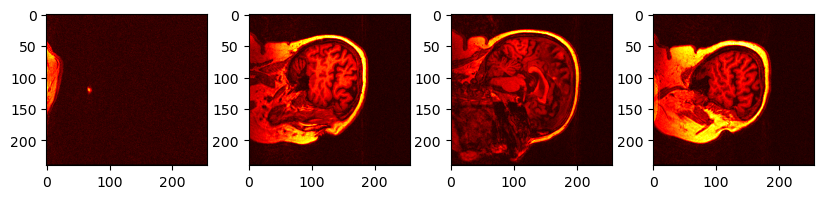

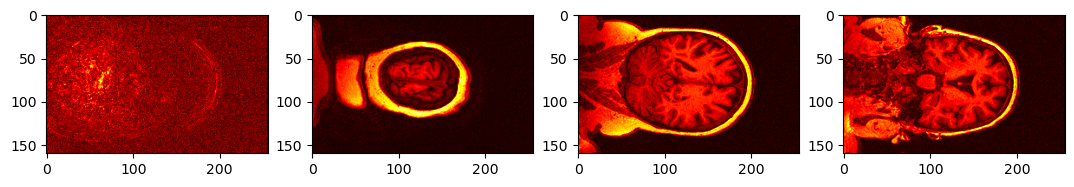

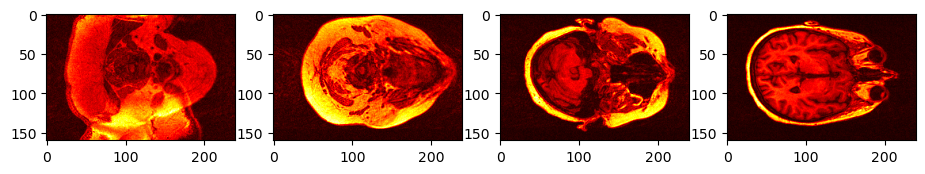

In [20]:
img_t1 = img[:,:,:]
num_img = len(list(range(0,img.shape[0],40)))
fig = plt.figure(figsize=(10, 2), dpi=100)
for i,p in enumerate(range(0,img.shape[0],40)):
    ax1 = fig.add_subplot(1,num_img,i+1)
    plt.imshow(img_t1[p,:,:], cmap = 'hot')
    
num_img = len(list(range(0,img.shape[1],40)))
fig = plt.figure(figsize=(20, 2), dpi=100)
for i,p in enumerate(range(0,img.shape[0],40)):
    ax1 = fig.add_subplot(1,num_img,i+1)
    plt.imshow(img_t1[:,p,:], cmap = 'hot')
    
num_img = len(list(range(0,img.shape[2],40)))
fig = plt.figure(figsize=(20, 2), dpi=100)
for i,p in enumerate(range(0,img.shape[0],40)):
    ax1 = fig.add_subplot(1,num_img,i+1)
    plt.imshow(img_t1[:,:,p], cmap = 'hot')

### If defacing is needed

In [4]:
for file in tqdm(os.listdir(clean_dir)):
    if os.path.isdir(os.path.join(clean_dir, file)):
        if os.path.exists(os.path.join(clean_dir, file, '{}.nii'.format(file))):
            if not os.path.exists(os.path.join(clean_dir, file, file + '_defaced.nii')):                
                nifti_file = os.path.join(clean_dir, file, '{}.nii'.format(file))
                print('Defacing', nifti_file)
                os.system('pydeface ' + nifti_file)

  0%|          | 0/604 [00:00<?, ?it/s]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5968WLY-1-2/S5968WLY-1-2.nii


 58%|█████▊    | 351/604 [04:07<02:58,  1.42it/s]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5010RSX-1-2/S5010RSX-1-2.nii


 58%|█████▊    | 352/604 [08:06<07:01,  1.67s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6200WBG-1-2/S6200WBG-1-2.nii


 58%|█████▊    | 353/604 [13:11<14:18,  3.42s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5941GYY-1-2/S5941GYY-1-2.nii


 59%|█████▊    | 354/604 [17:25<22:45,  5.46s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1672EFT-1-2/S1672EFT-1-2.nii


 59%|█████▉    | 355/604 [21:10<33:08,  7.99s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8846ELM-1-2/S8846ELM-1-2.nii


 59%|█████▉    | 356/604 [24:40<46:35, 11.27s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0693KNW-1-2/S0693KNW-1-2.nii


 59%|█████▉    | 357/604 [28:59<1:09:25, 16.86s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0220FCV-1-2/S0220FCV-1-2.nii


 59%|█████▉    | 358/604 [32:59<1:37:42, 23.83s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8654RHC-1-2/S8654RHC-1-2.nii


 59%|█████▉    | 359/604 [36:55<2:14:27, 32.93s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5107XMC-1-3/S5107XMC-1-3.nii


 60%|█████▉    | 360/604 [40:42<2:59:14, 44.08s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5225RTC-1-2/S5225RTC-1-2.nii


 60%|█████▉    | 361/604 [44:15<3:50:28, 56.91s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8563XGD-1-2/S8563XGD-1-2.nii


 60%|█████▉    | 362/604 [47:42<4:49:05, 71.68s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4137TIF-1-2/S4137TIF-1-2.nii


 60%|██████    | 363/604 [51:19<5:59:23, 89.47s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4390HMW-1-2/S4390HMW-1-2.nii


 60%|██████    | 364/604 [54:53<7:12:04, 108.02s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9119BEX-1-2/S9119BEX-1-2.nii


 60%|██████    | 365/604 [58:37<8:31:23, 128.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3536UYI-1-2/S3536UYI-1-2.nii


 61%|██████    | 366/604 [1:02:48<10:07:09, 153.06s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0733QUT-1-2/S0733QUT-1-2.nii


 61%|██████    | 367/604 [1:06:31<11:06:04, 168.63s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9676GNN-2-2/S9676GNN-2-2.nii


 61%|██████    | 368/604 [1:10:25<12:05:22, 184.42s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0415LUA-1-2/S0415LUA-1-2.nii


 61%|██████    | 369/604 [1:14:28<13:00:52, 199.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8078DQM-1-2/S8078DQM-1-2.nii


 61%|██████▏   | 370/604 [1:18:19<13:31:02, 207.96s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3419MNJ-1-2/S3419MNJ-1-2.nii


 61%|██████▏   | 371/604 [1:21:56<13:36:59, 210.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8626UFY-1-2/S8626UFY-1-2.nii


 62%|██████▏   | 372/604 [1:26:14<14:25:32, 223.85s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3593KLE-1-2/S3593KLE-1-2.nii


 62%|██████▏   | 373/604 [1:32:54<17:37:13, 274.60s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7701LXR-1-2/S7701LXR-1-2.nii


 62%|██████▏   | 374/604 [1:42:50<23:31:58, 368.34s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4214IRT-1-2/S4214IRT-1-2.nii


 62%|██████▏   | 375/604 [1:53:36<28:37:57, 450.12s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0228YSG-1-2/S0228YSG-1-2.nii


 62%|██████▏   | 376/604 [2:04:28<32:17:45, 509.94s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4529VYL-1-2/S4529VYL-1-2.nii


 62%|██████▏   | 377/604 [2:14:01<33:20:06, 528.66s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3856LVS-1-2/S3856LVS-1-2.nii


 63%|██████▎   | 378/604 [2:25:21<36:00:37, 573.62s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3421BGP-1-2/S3421BGP-1-2.nii


 63%|██████▎   | 379/604 [2:36:24<37:31:56, 600.52s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7889OYU-1-2/S7889OYU-1-2.nii


 63%|██████▎   | 380/604 [2:44:06<34:47:06, 559.05s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8035KVV-1-2/S8035KVV-1-2.nii


 63%|██████▎   | 381/604 [2:57:40<39:21:33, 635.40s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3504VUC-1-2/S3504VUC-1-2.nii


 63%|██████▎   | 382/604 [3:06:36<37:20:04, 605.43s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3263PNE-1-2/S3263PNE-1-2.nii


 63%|██████▎   | 383/604 [3:13:05<33:11:40, 540.73s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6032SGU-1-2/S6032SGU-1-2.nii


 64%|██████▎   | 384/604 [3:19:03<29:41:03, 485.74s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0673JFT-1-2/S0673JFT-1-2.nii


 64%|██████▎   | 385/604 [3:25:05<27:17:47, 448.71s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7857DLD-1-2/S7857DLD-1-2.nii


 64%|██████▍   | 386/604 [3:31:24<25:55:03, 428.00s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3441EPF-1-2/S3441EPF-1-2.nii


 64%|██████▍   | 387/604 [3:37:25<24:35:01, 407.84s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8440LLN-1-2/S8440LLN-1-2.nii


 64%|██████▍   | 388/604 [3:42:52<23:00:35, 383.50s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2875UFG-1-2/S2875UFG-1-2.nii


 64%|██████▍   | 389/604 [3:47:43<21:14:46, 355.75s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9854FIA-1-2/S9854FIA-1-2.nii


 65%|██████▍   | 390/604 [3:53:43<21:13:47, 357.14s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7612NJP-1-2/S7612NJP-1-2.nii


 65%|██████▍   | 391/604 [3:59:28<20:54:27, 353.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1453PAD-1-2/S1453PAD-1-2.nii


 65%|██████▍   | 392/604 [4:05:02<20:28:26, 347.67s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5232QLD-1-2/S5232QLD-1-2.nii


 65%|██████▌   | 393/604 [4:10:30<20:02:02, 341.81s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5846INM-1-2/S5846INM-1-2.nii


 65%|██████▌   | 394/604 [4:15:42<19:24:11, 332.62s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4939OGQ-1-2/S4939OGQ-1-2.nii


 65%|██████▌   | 395/604 [4:20:37<18:39:39, 321.43s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9188KFH-1-2/S9188KFH-1-2.nii


 66%|██████▌   | 396/604 [4:25:09<17:43:15, 306.71s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2818QYB-1-2/S2818QYB-1-2.nii


 66%|██████▌   | 397/604 [4:30:40<18:02:51, 313.87s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7670GNB-1-2/S7670GNB-1-2.nii


 66%|██████▌   | 398/604 [4:36:04<18:08:30, 317.04s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4928VWB-2-2/S4928VWB-2-2.nii


 66%|██████▌   | 399/604 [4:40:57<17:38:40, 309.86s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9570DLQ-1-2/S9570DLQ-1-2.nii


 66%|██████▌   | 400/604 [4:44:42<16:06:31, 284.27s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1820AEM-1-2/S1820AEM-1-2.nii


 66%|██████▋   | 401/604 [4:49:28<16:03:52, 284.89s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8222JCU-1-2/S8222JCU-1-2.nii


 67%|██████▋   | 402/604 [4:53:24<15:09:46, 270.23s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9008WRD-1-2/S9008WRD-1-2.nii


 67%|██████▋   | 403/604 [4:57:02<14:12:50, 254.58s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1908SEP-1-2/S1908SEP-1-2.nii


 67%|██████▋   | 404/604 [5:00:30<13:21:16, 240.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9420OPI-1-2/S9420OPI-1-2.nii


 67%|██████▋   | 405/604 [5:04:06<12:53:05, 233.09s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0669IVD-2-2/S0669IVD-2-2.nii


 67%|██████▋   | 406/604 [5:07:27<12:17:31, 223.49s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2331AWD-1-2/S2331AWD-1-2.nii


 67%|██████▋   | 407/604 [5:10:49<11:52:40, 217.06s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9145AHE-1-3/S9145AHE-1-3.nii


 68%|██████▊   | 408/604 [5:14:40<12:03:18, 221.42s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1294CWB-1-2/S1294CWB-1-2.nii


 68%|██████▊   | 409/604 [5:18:05<11:43:00, 216.31s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2076MGO-1-2/S2076MGO-1-2.nii


 68%|██████▊   | 410/604 [5:21:38<11:36:19, 215.36s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2251PEJ-1-3/S2251PEJ-1-3.nii


 68%|██████▊   | 411/604 [5:26:10<12:27:12, 232.29s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5735FYL-1-2/S5735FYL-1-2.nii


 68%|██████▊   | 412/604 [5:29:32<11:54:49, 223.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9161HEP-1-2/S9161HEP-1-2.nii


 68%|██████▊   | 413/604 [5:33:30<12:04:49, 227.69s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7868OKG-1-2/S7868OKG-1-2.nii


 69%|██████▊   | 414/604 [5:37:01<11:44:43, 222.54s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3127AHJ-1-2/S3127AHJ-1-2.nii


 69%|██████▊   | 415/604 [5:40:51<11:48:21, 224.87s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3982ODD-1-2/S3982ODD-1-2.nii


 69%|██████▉   | 416/604 [5:44:29<11:37:52, 222.73s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4100EOM-1-2/S4100EOM-1-2.nii


 69%|██████▉   | 417/604 [5:48:03<11:26:50, 220.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2764XYH-1-2/S2764XYH-1-2.nii


 69%|██████▉   | 418/604 [5:51:33<11:13:10, 217.16s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7277YPL-1-2/S7277YPL-1-2.nii


 69%|██████▉   | 419/604 [5:55:22<11:20:22, 220.66s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6014LIN-1-2/S6014LIN-1-2.nii


 70%|██████▉   | 420/604 [5:58:43<10:58:37, 214.77s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2285YBL-1-2/S2285YBL-1-2.nii


 70%|██████▉   | 421/604 [6:02:11<10:49:09, 212.84s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3728OQP-2-2/S3728OQP-2-2.nii


 70%|██████▉   | 422/604 [6:05:39<10:40:39, 211.21s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3530YHM-1-2/S3530YHM-1-2.nii


 70%|███████   | 423/604 [6:09:30<10:55:09, 217.18s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2044XNA-1-2/S2044XNA-1-2.nii


 70%|███████   | 424/604 [6:13:19<11:01:58, 220.66s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1967DMU-1-2/S1967DMU-1-2.nii


 70%|███████   | 425/604 [6:16:41<10:41:34, 215.05s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4561YRI-1-2/S4561YRI-1-2.nii


 71%|███████   | 426/604 [6:20:10<10:33:04, 213.39s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4660VSC-1-2/S4660VSC-1-2.nii


 71%|███████   | 427/604 [6:23:47<10:32:43, 214.49s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4673PTE-1-2/S4673PTE-1-2.nii


 71%|███████   | 428/604 [6:27:18<10:25:39, 213.29s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5409IFQ-1-2/S5409IFQ-1-2.nii


 71%|███████   | 429/604 [6:31:05<10:34:41, 217.61s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4499XDH-1-2/S4499XDH-1-2.nii


 71%|███████   | 430/604 [6:35:17<11:00:17, 227.68s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2268SWJ-1-4/S2268SWJ-1-4.nii


 71%|███████▏  | 431/604 [6:39:06<10:58:27, 228.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4463JBA-1-2/S4463JBA-1-2.nii


 72%|███████▏  | 432/604 [6:42:51<10:51:18, 227.20s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8624XVV-1-2/S8624XVV-1-2.nii


 72%|███████▏  | 433/604 [6:46:33<10:42:42, 225.51s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0251JUF-1-2/S0251JUF-1-2.nii


 72%|███████▏  | 434/604 [6:49:54<10:18:14, 218.20s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7635IMJ-1-2/S7635IMJ-1-2.nii


 72%|███████▏  | 435/604 [6:53:37<10:18:57, 219.75s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8201IRF-1-2/S8201IRF-1-2.nii


 72%|███████▏  | 436/604 [6:57:48<10:41:32, 229.12s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1841IJS-1-2/S1841IJS-1-2.nii


 72%|███████▏  | 437/604 [7:01:17<10:20:54, 223.08s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1680RWH-1-2/S1680RWH-1-2.nii


 73%|███████▎  | 438/604 [7:04:50<10:09:09, 220.18s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3711OVC-1-2/S3711OVC-1-2.nii


 73%|███████▎  | 439/604 [7:08:19<9:55:32, 216.56s/it] 

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7880FUY-1-2/S7880FUY-1-2.nii


 73%|███████▎  | 440/604 [7:11:43<9:42:18, 213.04s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3551WCD-1-3/S3551WCD-1-3.nii


 73%|███████▎  | 441/604 [7:15:19<9:41:01, 213.87s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0432FES-1-2/S0432FES-1-2.nii


 73%|███████▎  | 442/604 [7:18:55<9:38:54, 214.41s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9269RWX-1-2/S9269RWX-1-2.nii


 73%|███████▎  | 443/604 [7:22:41<9:44:57, 218.00s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9061TUS-1-2/S9061TUS-1-2.nii


 74%|███████▎  | 444/604 [7:26:19<9:41:30, 218.07s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4723GMF-1-2/S4723GMF-1-2.nii


 74%|███████▎  | 445/604 [7:29:51<9:32:26, 216.02s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5700TWG-1-2/S5700TWG-1-2.nii


 74%|███████▍  | 446/604 [7:33:29<9:30:58, 216.82s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7445FQP-1-2/S7445FQP-1-2.nii


 74%|███████▍  | 447/604 [7:37:06<9:27:25, 216.85s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0162SNQ-1-2/S0162SNQ-1-2.nii


 74%|███████▍  | 448/604 [7:41:10<9:45:04, 225.03s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2666RNR-1-2/S2666RNR-1-2.nii


 74%|███████▍  | 449/604 [7:45:12<9:53:51, 229.88s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2978DMJ-1-2/S2978DMJ-1-2.nii


 75%|███████▍  | 450/604 [7:48:36<9:30:09, 222.14s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4682UJX-1-2/S4682UJX-1-2.nii


 75%|███████▍  | 451/604 [7:52:10<9:20:08, 219.66s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3217OQE-1-2/S3217OQE-1-2.nii


 75%|███████▍  | 452/604 [7:55:53<9:19:41, 220.93s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9958PLR-1-2/S9958PLR-1-2.nii


 75%|███████▌  | 453/604 [7:59:32<9:14:02, 220.15s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8643NYV-1-2/S8643NYV-1-2.nii


 75%|███████▌  | 454/604 [8:02:57<8:59:02, 215.61s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3446DTK-1-2/S3446DTK-1-2.nii


 75%|███████▌  | 455/604 [8:06:31<8:54:28, 215.22s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2207DTM-1-2/S2207DTM-1-2.nii


 75%|███████▌  | 456/604 [8:10:50<9:23:19, 228.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0446SHD-1-2/S0446SHD-1-2.nii


 76%|███████▌  | 457/604 [8:14:48<9:26:19, 231.15s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5722XHH-1-2/S5722XHH-1-2.nii


 76%|███████▌  | 458/604 [8:18:31<9:16:22, 228.64s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3033SJJ-1-2/S3033SJJ-1-2.nii


 76%|███████▌  | 459/604 [8:22:02<8:59:56, 223.43s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0149USU-1-2/S0149USU-1-2.nii


 76%|███████▌  | 460/604 [8:25:38<8:50:45, 221.15s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8554AUS-1-2/S8554AUS-1-2.nii


 76%|███████▋  | 461/604 [8:29:23<8:49:52, 222.32s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8372WQW-1-2/S8372WQW-1-2.nii


 76%|███████▋  | 462/604 [8:33:22<8:58:10, 227.39s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7110CBM-1-2/S7110CBM-1-2.nii


 77%|███████▋  | 463/604 [8:36:51<8:41:27, 221.90s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2792BOB-1-2/S2792BOB-1-2.nii


 77%|███████▋  | 464/604 [8:40:52<8:50:56, 227.55s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0571EYN-2-2/S0571EYN-2-2.nii


 77%|███████▋  | 465/604 [8:44:46<8:51:52, 229.58s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5317QPN-1-2/S5317QPN-1-2.nii


 77%|███████▋  | 466/604 [8:49:51<9:40:16, 252.29s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1513KBH-1-2/S1513KBH-1-2.nii


 77%|███████▋  | 467/604 [8:53:14<9:01:56, 237.35s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6549MXR-1-3/S6549MXR-1-3.nii


 78%|███████▊  | 469/604 [8:56:39<5:58:39, 159.40s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1940ASN-1-10/S1940ASN-1-10.nii


 78%|███████▊  | 473/604 [9:00:16<3:10:16, 87.15s/it] 

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2707LVO-1-9/S2707LVO-1-9.nii


 79%|███████▉  | 479/604 [9:04:12<1:52:12, 53.86s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0514JHY-1-5/S0514JHY-1-5.nii


 79%|███████▉  | 480/604 [9:07:57<2:52:34, 83.51s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3133DQA-1-3/S3133DQA-1-3.nii


 80%|███████▉  | 481/604 [9:11:49<3:51:47, 113.07s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7550KEG-1-3/S7550KEG-1-3.nii


 80%|███████▉  | 482/604 [9:16:47<5:12:34, 153.73s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5754FFB-1-3/S5754FFB-1-3.nii


 80%|███████▉  | 483/604 [9:25:36<8:11:53, 243.91s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2829UOK-1-3/S2829UOK-1-3.nii


 80%|████████  | 484/604 [9:29:47<8:11:19, 245.66s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4502PNC-1-3/S4502PNC-1-3.nii


 80%|████████  | 485/604 [9:33:55<8:08:13, 246.17s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1947HVS-2-4/S1947HVS-2-4.nii


 80%|████████  | 486/604 [9:37:30<7:47:16, 237.60s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3982VWA-1-3/S3982VWA-1-3.nii


 81%|████████  | 487/604 [9:44:55<9:37:38, 296.23s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2882HCQ-1-3/S2882HCQ-1-3.nii


 81%|████████  | 488/604 [9:50:48<10:04:32, 312.69s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4648HNK-1-7/S4648HNK-1-7.nii


 81%|████████  | 489/604 [9:54:49<9:19:10, 291.74s/it] 

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8452DQA-1-3/S8452DQA-1-3.nii


 81%|████████  | 490/604 [9:58:08<8:22:43, 264.59s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3110FBP-1-2/S3110FBP-1-2.nii


 81%|████████▏ | 491/604 [10:02:01<8:00:38, 255.20s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6374WQT-1-2/S6374WQT-1-2.nii


 81%|████████▏ | 492/604 [10:06:20<7:58:39, 256.42s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7879FYP-1-3/S7879FYP-1-3.nii


 82%|████████▏ | 493/604 [10:10:06<7:37:30, 247.30s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9530VJR-1-2/S9530VJR-1-2.nii


 82%|████████▏ | 494/604 [10:17:33<9:22:28, 306.80s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1802FQX-1-5/S1802FQX-1-5.nii


 82%|████████▏ | 495/604 [10:20:56<8:21:12, 275.90s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3953USF-1-4/S3953USF-1-4.nii


 82%|████████▏ | 496/604 [10:24:38<7:47:29, 259.72s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8097YUQ-1-3/S8097YUQ-1-3.nii


 82%|████████▏ | 497/604 [10:28:15<7:20:08, 246.81s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7972MLR-1-2/S7972MLR-1-2.nii


 82%|████████▏ | 498/604 [10:34:35<8:26:42, 286.81s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2470JXQ-1-2/S2470JXQ-1-2.nii


 83%|████████▎ | 499/604 [10:40:19<8:51:58, 303.98s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3487MCJ-1-2/S3487MCJ-1-2.nii


 83%|████████▎ | 500/604 [10:44:07<8:07:03, 280.99s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6622MSM-1-4/S6622MSM-1-4.nii


 83%|████████▎ | 501/604 [10:49:48<8:33:29, 299.12s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6548PID-1-4/S6548PID-1-4.nii


 83%|████████▎ | 502/604 [10:53:30<7:49:26, 276.14s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8819AVE-1-3/S8819AVE-1-3.nii


 83%|████████▎ | 503/604 [10:57:10<7:16:03, 259.04s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8914KMW-1-3/S8914KMW-1-3.nii


 83%|████████▎ | 504/604 [11:02:02<7:28:21, 269.02s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2982KFG-2-3/S2982KFG-2-3.nii


 84%|████████▎ | 505/604 [11:05:55<7:05:53, 258.12s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9665TBK-1-3/S9665TBK-1-3.nii


 84%|████████▍ | 506/604 [11:10:21<7:05:33, 260.55s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5584INV-1-2/S5584INV-1-2.nii


 84%|████████▍ | 507/604 [11:15:16<7:17:57, 270.90s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3715XQE-1-3/S3715XQE-1-3.nii


 84%|████████▍ | 508/604 [11:18:47<6:44:56, 253.09s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7644TYV-2-3/S7644TYV-2-3.nii


 84%|████████▍ | 509/604 [11:23:02<6:41:40, 253.69s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5342VIQ-1-5/S5342VIQ-1-5.nii


 84%|████████▍ | 510/604 [11:27:29<6:43:15, 257.40s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2123CPN-1-2/S2123CPN-1-2.nii


 85%|████████▍ | 511/604 [11:32:16<6:52:52, 266.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4649UJH-1-3/S4649UJH-1-3.nii


 85%|████████▍ | 512/604 [11:36:31<6:43:17, 263.01s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7880GNL-1-3/S7880GNL-1-3.nii


 85%|████████▍ | 513/604 [11:43:02<7:37:12, 301.46s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8048ECC-1-2/S8048ECC-1-2.nii


 85%|████████▌ | 514/604 [11:46:34<6:52:03, 274.70s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7495GXB-1-2/S7495GXB-1-2.nii


 85%|████████▌ | 515/604 [11:50:11<6:21:41, 257.32s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7153GAT-1-3/S7153GAT-1-3.nii


 85%|████████▌ | 516/604 [11:54:02<6:05:53, 249.47s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9321JGA-1-3/S9321JGA-1-3.nii


 86%|████████▌ | 517/604 [11:57:54<5:53:57, 244.11s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3977UNW-1-2/S3977UNW-1-2.nii


 86%|████████▌ | 518/604 [12:01:42<5:43:08, 239.40s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4654AKL-1-2/S4654AKL-1-2.nii


 86%|████████▌ | 519/604 [12:08:24<6:48:16, 288.20s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2579EUK-1-2/S2579EUK-1-2.nii


 86%|████████▌ | 520/604 [12:12:53<6:35:08, 282.24s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9969KOO-1-3/S9969KOO-1-3.nii


 86%|████████▋ | 521/604 [12:17:02<6:16:46, 272.37s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2566PTC-1-3/S2566PTC-1-3.nii


 86%|████████▋ | 522/604 [12:20:30<5:45:56, 253.13s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3373DFC-2-3/S3373DFC-2-3.nii


 87%|████████▋ | 523/604 [12:27:40<6:53:05, 306.00s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0844GBL-1-2/S0844GBL-1-2.nii


 87%|████████▋ | 524/604 [12:31:02<6:06:37, 274.96s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8238KRG-1-3/S8238KRG-1-3.nii


 87%|████████▋ | 525/604 [12:35:14<5:52:53, 268.02s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3979MAH-1-4/S3979MAH-1-4.nii


 87%|████████▋ | 526/604 [12:39:00<5:32:11, 255.54s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2173RAK-1-5/S2173RAK-1-5.nii


 87%|████████▋ | 527/604 [12:45:43<6:24:36, 299.70s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7185KXS-1-3/S7185KXS-1-3.nii


 87%|████████▋ | 528/604 [12:49:20<5:47:59, 274.73s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6057CGW-1-4/S6057CGW-1-4.nii


 88%|████████▊ | 529/604 [12:53:57<5:44:28, 275.57s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6144YXD-1-3/S6144YXD-1-3.nii


 88%|████████▊ | 530/604 [12:57:50<5:23:53, 262.61s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1664MXN-1-3/S1664MXN-1-3.nii


 88%|████████▊ | 531/604 [13:02:34<5:27:25, 269.11s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2935RDF-1-3/S2935RDF-1-3.nii


 88%|████████▊ | 532/604 [13:08:16<5:49:21, 291.14s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1427EWF-1-2/S1427EWF-1-2.nii


 88%|████████▊ | 533/604 [13:11:41<5:13:47, 265.18s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9380UKV-1-2/S9380UKV-1-2.nii


 88%|████████▊ | 534/604 [13:16:46<5:23:09, 276.99s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7444STM-1-4/S7444STM-1-4.nii


 89%|████████▊ | 535/604 [13:21:39<5:24:09, 281.88s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3195SGY-1-3/S3195SGY-1-3.nii


 89%|████████▊ | 536/604 [13:25:49<5:08:41, 272.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3645PCU-1-3/S3645PCU-1-3.nii


 89%|████████▉ | 537/604 [13:29:45<4:51:50, 261.35s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6198GMS-1-4/S6198GMS-1-4.nii


 89%|████████▉ | 538/604 [13:37:11<5:48:29, 316.81s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3466IHM-1-2/S3466IHM-1-2.nii


 89%|████████▉ | 539/604 [13:40:51<5:11:55, 287.92s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6494IXR-1-3/S6494IXR-1-3.nii


 89%|████████▉ | 540/604 [13:45:27<5:03:04, 284.14s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7265PEN-1-5/S7265PEN-1-5.nii


 90%|████████▉ | 541/604 [13:49:22<4:42:49, 269.36s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7455FRR-1-5/S7455FRR-1-5.nii


 90%|████████▉ | 542/604 [13:53:57<4:40:19, 271.28s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3234QAO-1-2/S3234QAO-1-2.nii


 90%|████████▉ | 543/604 [13:58:45<4:40:54, 276.30s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9434EYS-1-4/S9434EYS-1-4.nii


 90%|█████████ | 544/604 [14:04:53<5:03:43, 303.72s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2539VRD-1-2/S2539VRD-1-2.nii


 90%|█████████ | 545/604 [14:09:17<4:46:48, 291.67s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9109UIT-1-3/S9109UIT-1-3.nii


 91%|█████████ | 547/604 [14:15:59<3:36:02, 227.41s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2802HOM-1-2/S2802HOM-1-2.nii


 91%|█████████ | 548/604 [14:21:40<4:04:13, 261.66s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6380NRN-1-6/S6380NRN-1-6.nii


 91%|█████████ | 549/604 [14:26:48<4:12:29, 275.45s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6508VLT-1-3/S6508VLT-1-3.nii


 91%|█████████ | 550/604 [14:31:04<4:02:37, 269.57s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6235JQU-1-4/S6235JQU-1-4.nii


 91%|█████████ | 551/604 [14:36:19<4:10:15, 283.31s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0593TNF-1-3/S0593TNF-1-3.nii


 91%|█████████▏| 552/604 [14:41:36<4:14:14, 293.36s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8898JKS-1-3/S8898JKS-1-3.nii


 92%|█████████▏| 553/604 [14:48:27<4:39:19, 328.61s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0253BRK-1-4/S0253BRK-1-4.nii


 92%|█████████▏| 554/604 [14:58:38<5:44:34, 413.48s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2589KRB-1-4/S2589KRB-1-4.nii


 92%|█████████▏| 555/604 [15:02:30<4:53:04, 358.87s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3420RFK-1-3/S3420RFK-1-3.nii


 92%|█████████▏| 556/604 [15:07:42<4:35:53, 344.87s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7139QML-1-3/S7139QML-1-3.nii


 92%|█████████▏| 557/604 [15:16:06<5:07:25, 392.46s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5682XQD-1-3/S5682XQD-1-3.nii


 92%|█████████▏| 558/604 [15:24:20<5:24:14, 422.93s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9634DCK-1-5/S9634DCK-1-5.nii


 93%|█████████▎| 559/604 [15:32:03<5:26:11, 434.93s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2621LCR-1-3/S2621LCR-1-3.nii


 93%|█████████▎| 560/604 [15:38:41<5:10:55, 423.98s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9291AFK-1-3/S9291AFK-1-3.nii


 93%|█████████▎| 561/604 [15:45:04<4:55:07, 411.81s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2887QDY-1-2/S2887QDY-1-2.nii


 93%|█████████▎| 562/604 [15:55:59<5:39:19, 484.76s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8892KRM-1-3/S8892KRM-1-3.nii


 93%|█████████▎| 563/604 [16:03:39<5:26:08, 477.29s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5052VXV-1-2/S5052VXV-1-2.nii


 93%|█████████▎| 564/604 [16:10:26<5:04:01, 456.04s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2198GTK-1-2/S2198GTK-1-2.nii


 94%|█████████▎| 565/604 [16:16:05<4:33:38, 420.99s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5126WLO-1-7/S5126WLO-1-7.nii


 94%|█████████▎| 566/604 [16:22:19<4:17:48, 407.08s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7767PEE-1-2/S7767PEE-1-2.nii


 94%|█████████▍| 567/604 [16:26:27<3:41:30, 359.21s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8704FPR-1-3/S8704FPR-1-3.nii


 94%|█████████▍| 568/604 [16:34:08<3:53:49, 389.70s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0370IRG-1-3/S0370IRG-1-3.nii


 94%|█████████▍| 569/604 [16:38:08<3:21:06, 344.77s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0092SVK-1-4/S0092SVK-1-4.nii


 94%|█████████▍| 570/604 [16:41:49<2:54:22, 307.74s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5228GXD-1-3/S5228GXD-1-3.nii


 95%|█████████▍| 571/604 [16:45:50<2:38:17, 287.80s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6572CVP-1-2/S6572CVP-1-2.nii


 95%|█████████▍| 572/604 [16:50:26<2:31:36, 284.27s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2969HYD-1-2/S2969HYD-1-2.nii


 95%|█████████▍| 573/604 [16:57:09<2:45:09, 319.67s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7777AQF-1-3/S7777AQF-1-3.nii


 95%|█████████▌| 574/604 [17:01:45<2:33:16, 306.55s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0130WTD-1-3/S0130WTD-1-3.nii


 95%|█████████▌| 575/604 [17:06:43<2:27:02, 304.21s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7957ETQ-1-6/S7957ETQ-1-6.nii


 95%|█████████▌| 576/604 [17:11:30<2:19:33, 299.06s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5588UYV-1-3/S5588UYV-1-3.nii


 96%|█████████▌| 577/604 [17:18:52<2:33:48, 341.78s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6898CPI-1-2/S6898CPI-1-2.nii


 96%|█████████▌| 578/604 [17:23:13<2:17:40, 317.72s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9300MWM-1-3/S9300MWM-1-3.nii


 96%|█████████▌| 579/604 [17:28:47<2:14:21, 322.47s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S7510LXD-1-2/S7510LXD-1-2.nii


 96%|█████████▌| 580/604 [17:34:33<2:11:47, 329.50s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0918COD-1-3/S0918COD-1-3.nii


 96%|█████████▌| 581/604 [17:38:45<1:57:27, 306.41s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1279QLI-1-2/S1279QLI-1-2.nii


 96%|█████████▋| 582/604 [17:43:36<1:50:39, 301.78s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S2461GCP-1-3/S2461GCP-1-3.nii


 97%|█████████▋| 583/604 [17:48:55<1:47:22, 306.80s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S4762AVJ-1-3/S4762AVJ-1-3.nii


 97%|█████████▋| 584/604 [17:54:16<1:43:40, 311.02s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3520XHL-1-3/S3520XHL-1-3.nii


 97%|█████████▋| 585/604 [17:59:51<1:40:49, 318.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8477NVY-1-3/S8477NVY-1-3.nii


 97%|█████████▋| 586/604 [18:04:23<1:31:18, 304.35s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0161SDH-1-3/S0161SDH-1-3.nii


 97%|█████████▋| 587/604 [18:09:08<1:24:37, 298.65s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8429UBR-1-2/S8429UBR-1-2.nii


 97%|█████████▋| 588/604 [18:14:27<1:21:16, 304.80s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1354OKV-1-2/S1354OKV-1-2.nii


 98%|█████████▊| 589/604 [18:19:02<1:13:54, 295.65s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3174RYN-1-3/S3174RYN-1-3.nii


 98%|█████████▊| 590/604 [18:24:31<1:11:19, 305.67s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0477VUR-3-4/S0477VUR-3-4.nii


 98%|█████████▊| 591/604 [18:31:16<1:12:39, 335.38s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1579FNY-1-2/S1579FNY-1-2.nii


 98%|█████████▊| 592/604 [18:38:00<1:11:13, 356.09s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3528MNO-1-4/S3528MNO-1-4.nii


 98%|█████████▊| 593/604 [18:43:36<1:04:09, 349.97s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9397GNF-1-3/S9397GNF-1-3.nii


 98%|█████████▊| 594/604 [18:48:49<56:29, 338.93s/it]  

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8538DCN-1-3/S8538DCN-1-3.nii


 99%|█████████▊| 595/604 [18:52:55<46:40, 311.14s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S6050UKY-1-2/S6050UKY-1-2.nii


 99%|█████████▊| 596/604 [18:58:47<43:05, 323.24s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S8333ADY-1-3/S8333ADY-1-3.nii


 99%|█████████▉| 597/604 [19:03:45<36:51, 315.91s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3021HYS-1-3/S3021HYS-1-3.nii


 99%|█████████▉| 598/604 [19:09:01<31:34, 315.77s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0540CIH-1-6/S0540CIH-1-6.nii


 99%|█████████▉| 599/604 [19:14:12<26:12, 314.45s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S9210XGE-1-5/S9210XGE-1-5.nii


 99%|█████████▉| 600/604 [19:19:45<21:20, 320.05s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S5799TBU-1-4/S5799TBU-1-4.nii


100%|█████████▉| 601/604 [19:24:56<15:51, 317.13s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S3500OTV-1-3/S3500OTV-1-3.nii


100%|█████████▉| 602/604 [19:29:31<10:09, 304.59s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S0526FQI-1-3/S0526FQI-1-3.nii


100%|█████████▉| 603/604 [19:33:42<04:48, 288.58s/it]

Defacing ../physcosis/Package_1187332/image03/CLEAN/S1698NIH-1-3/S1698NIH-1-3.nii


100%|██████████| 604/604 [19:37:35<00:00, 116.98s/it]


In [14]:
master_table

,collection_id_x,image03_id,dataset_id_x,subjectkey_x,src_subject_id,interview_age,sex_x,comments_misc,image_file,image_description,...,gps_g7,gps_g8,gps_g9,gps_g10,gps_g11,gps_g12,gps_g13,gps_g14,gps_g15,gps_g16
0,2274,455311,11148,NDAR_INVENJK68TH,3494,324,F,ORIGINALPRIMARYMND,S7432UOB-1-2.zip,T1 MPRAGE,...,1,1,1,3,1,1,1,1,1,1
1,2274,455312,11148,NDAR_INVR1X1BJXH,3080,552,F,ORIGINALPRIMARYMND,S8240FWM-1-2.zip,T1 MPRAGE,...,3,1,1,1,1,4,1,1,1,3
2,2274,455314,11148,NDAR_INVET1RDAWC,2749,600,F,ORIGINALPRIMARYMND,S5568DSN-1-2.zip,T1 MPRAGE,...,1,2,1,2,1,2,4,1,1,5
3,2274,455316,11148,NDAR_INV0647UAN8,3034,288,F,ORIGINALPRIMARYMND,S9551QLO-1-2.zip,T1 MPRAGE,...,1,6,1,2,4,3,2,3,1,1
4,2274,455319,11148,NDAR_INVJ7GBZ7ND,3094,396,M,ORIGINALPRIMARYMND,S5520KMB-1-2.zip,T1 MPRAGE,...,3,1,4,3,2,6,3,3,3,4
5,2274,455320,11148,NDAR_INVECGL3MU5,3743,684,M,ORIGINALPRIMARYMND,S8171COF-1-2.zip,T1 MPRAGE,...,1,1,1,1,1,1,1,1,1,2
6,2274,455321,11148,NDAR_INVE7JLJZC4,2236,252,M,ORIGINALPRIMARYMND,S3535MBI-1-2.zip,T1 MPRAGE,...,2,1,1,2,1,2,4,1,1,1
7,2274,455322,11148,NDAR_INVCDD7RUMC,2584,564,M,ORIGINALPRIMARYMND,S8057AKX-1-2.zip,T1 MPRAGE,...,2,1,3,1,1,2,3,1,1,1
8,2274,455323,11148,NDAR_INVGBXTRJBD,2667,780,F,ORIGINALPRIMARYMND,S5782EGK-1-2.zip,T1 MPRAGE,...,1,1,1,2,1,1,1,1,1,1
9,2274,455324,11148,NDAR_INVYF12NKWH,2002,468,F,ORIGINALPRIMARYMND,S9222EPL-1-2.zip,T1 MPRAGE,...,1,1,1,2,4,1,3,3,2,3


In [19]:
final_dir = os.path.join(data_dir, 'FINAL')

if not os.path.exists(final_dir):
    os.mkdir(final_dir)

In [25]:
for file in tqdm(os.listdir(clean_dir)):
    if os.path.isdir(os.path.join(clean_dir, file)):
        if os.path.exists(os.path.join(clean_dir, file, file + '_defaced.nii')): 
            source = os.path.join(clean_dir, file, file + '_defaced.nii')
            dest = os.path.join(final_dir, file + '_defaced.nii')
            os.system('cp -r ' + source + ' ' + dest)
#             print('cp -r ' + source + ' ' + dest)

100%|██████████| 604/604 [03:31<00:00,  2.85it/s] 


In [26]:
new_paths = []
for i,row in master_table.iterrows():
    file = row['image_file'].split('.')[0]
    if os.path.exists(os.path.join(final_dir, file + '_defaced.nii')): 
        new_paths.append(os.path.join(final_dir, file + '_defaced.nii'))
    else:
        new_paths.append('bad_image')

In [27]:
print(len(new_paths))
print(master_table.shape)

301
(301, 108)


In [30]:
master_table['image_file'] = new_paths

In [34]:
master_table = master_table[master_table['image_file'] != 'bad_image']
master_table.shape

(291, 108)

In [35]:
print(len(os.listdir(final_dir)))

291


In [36]:
master_table.to_csv(os.path.join(final_dir, 'master_table.csv'), sep = '\t', index = False)

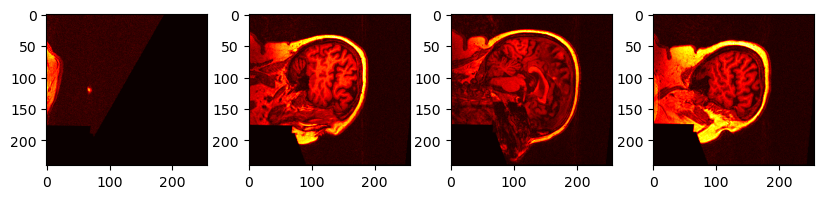

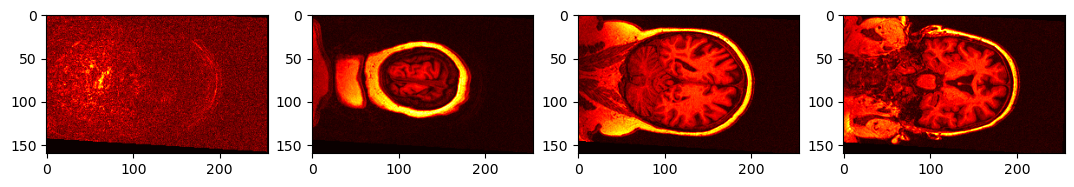

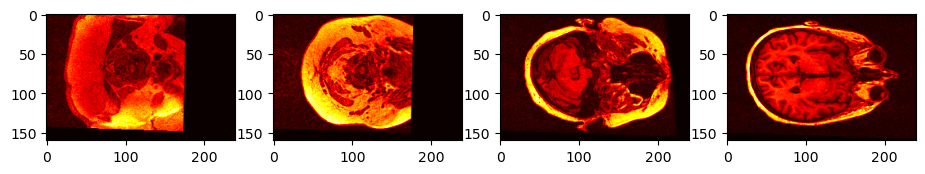

In [33]:
img = nib.load(os.path.join(final_dir, 'S0162SNQ-1-2_defaced.nii'))
img = img.get_fdata()
img_t1 = img[:,:,:]
num_img = len(list(range(0,img.shape[0],40)))
fig = plt.figure(figsize=(10, 2), dpi=100)
for i,p in enumerate(range(0,img.shape[0],40)):
    ax1 = fig.add_subplot(1,num_img,i+1)
    plt.imshow(img_t1[p,:,:], cmap = 'hot')
    
num_img = len(list(range(0,img.shape[1],40)))
fig = plt.figure(figsize=(20, 2), dpi=100)
for i,p in enumerate(range(0,img.shape[0],40)):
    ax1 = fig.add_subplot(1,num_img,i+1)
    plt.imshow(img_t1[:,p,:], cmap = 'hot')
    
num_img = len(list(range(0,img.shape[2],40)))
fig = plt.figure(figsize=(20, 2), dpi=100)
for i,p in enumerate(range(0,img.shape[0],40)):
    ax1 = fig.add_subplot(1,num_img,i+1)
    plt.imshow(img_t1[:,:,p], cmap = 'hot')